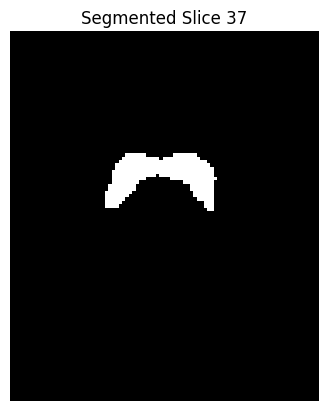

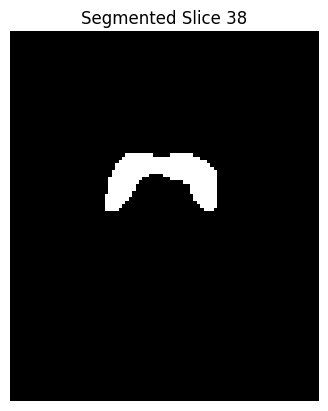

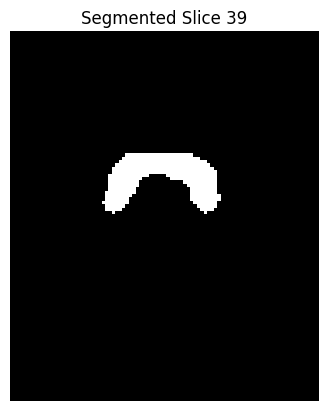

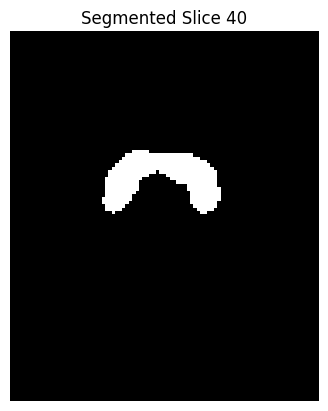

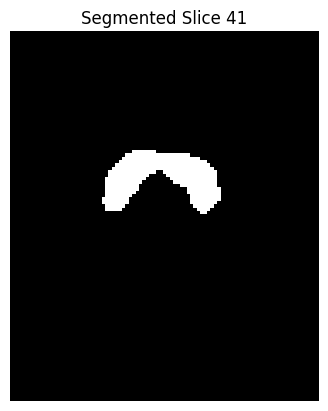

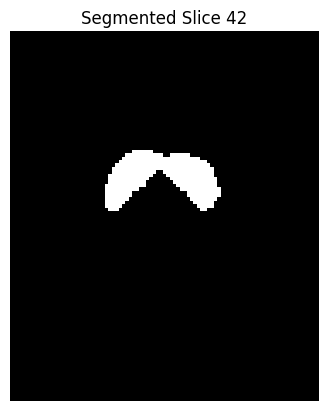

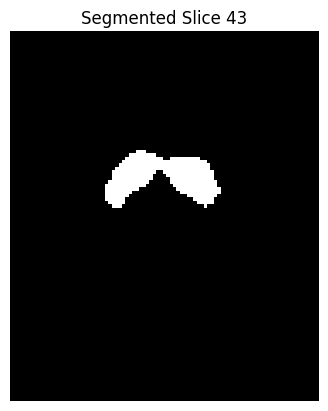

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pydicom 
from skimage import measure, exposure
import vtk
# def segment_coronal_view(dicom_dir, threshold_value=0.77999):
def segment_coronal_view(dicom_dir, threshold_value=0.57999):
    dicom_files = sorted([os.path.join(dicom_dir, file) for file in os.listdir(dicom_dir) if file.endswith('.dcm')])

    try:
        dicom_data = [pydicom.dcmread(file) for file in dicom_files]
        preprocessed_image_data = np.stack([dicom.pixel_array for dicom in dicom_data])

        # Remove single channel dimension if present
        preprocessed_image_data = np.squeeze(preprocessed_image_data)
    except Exception as e:
        print("Error loading DICOM data:", e)
        return None

    # Segmentation for coronal slices
    coronal_slices_to_visualize = list(range(37, 44))  # Slices 35 to 47
    num_slices = len(coronal_slices_to_visualize)

    merged_striatum_image = np.zeros_like(preprocessed_image_data, dtype=np.uint8)

    for slice_index in coronal_slices_to_visualize:
        # Get the coronal slice
        coronal_slice = preprocessed_image_data[slice_index, :, :]

        # Apply custom intensity transformation
        coronal_slice_contrast = exposure.rescale_intensity(coronal_slice, in_range='image', out_range=(0.1, 0.9))

        # Apply threshold to isolate the brightest part
        brightest_part = coronal_slice_contrast > np.max(coronal_slice_contrast) * threshold_value

        # Label connected components
        labeled_image, _ = measure.label(brightest_part, connectivity=2, return_num=True)

        # Find the largest connected component (assumed to be the striatum)
        region_props = measure.regionprops(labeled_image, intensity_image=coronal_slice)
        brightest_region_label = None
        brightest_mean_intensity = 0
        for region in region_props:
            if region.mean_intensity > brightest_mean_intensity:
                brightest_mean_intensity = region.mean_intensity
                brightest_region_label = region.label

        # Create mask for the brightest region
        brightest_region_mask = labeled_image == brightest_region_label

        # Overlay the mask on the original image
        merged_striatum_image[slice_index][brightest_region_mask] = 240

        # Print segmented slice
        plt.figure()
        plt.imshow(merged_striatum_image[slice_index], cmap='gray')
        plt.title(f'Segmented Slice {slice_index}')
        plt.axis('off')
        plt.show()

    return merged_striatum_image

def create_vtk_image(image_data):
    vtk_image = vtk.vtkImageData()
    vtk_image.SetDimensions(image_data.shape[2], image_data.shape[1], image_data.shape[0])
    vtk_image.AllocateScalars(vtk.VTK_UNSIGNED_CHAR, 1)

    for z in range(image_data.shape[0]):
        for y in range(image_data.shape[1]):
            for x in range(image_data.shape[2]):
                vtk_image.SetScalarComponentFromFloat(x, y, z, 0, image_data[z, y, x])

    return vtk_image

def create_vtk_actor(image_data):
    vtk_image = create_vtk_image(image_data)

    # Extract surface
    contour = vtk.vtkMarchingCubes()
    contour.SetInputData(vtk_image)
    contour.SetValue(0, 127)  # Adjust the threshold value if needed

    # Smooth the surface
    smoother = vtk.vtkSmoothPolyDataFilter()
    smoother.SetInputConnection(contour.GetOutputPort())
    smoother.SetNumberOfIterations(50)
    smoother.SetRelaxationFactor(0.1)

    # Create mapper
    mapper = vtk.vtkPolyDataMapper()
    mapper.SetInputConnection(smoother.GetOutputPort())

    # Create actor
    actor = vtk.vtkActor()
    actor.SetMapper(mapper)

    return actor

def visualize_3d_reconstruction(image_data):
    renderer = vtk.vtkRenderer()
    render_window = vtk.vtkRenderWindow()
    render_window.SetWindowName("3D Reconstruction Visualization")
    render_window.AddRenderer(renderer)
    render_window_interactor = vtk.vtkRenderWindowInteractor()
    render_window_interactor.SetRenderWindow(render_window)

    actor = create_vtk_actor(image_data)
    renderer.AddActor(actor)

    render_window.Render()
    render_window_interactor.Start()

# Path to DICOM directory
# dicom_dir = "B:/Sami Sir Research/Data set/DAT_PRE-P_S-ID(4100-4478)/PPMI/4100/Reconstructed_DaTSCAN/2012-11-13_13_33_30.0/I360623"
dicom_dir = "B:/Sami Sir Research/Data set/hc/PPMI/3370/Reconstructed_DaTSCAN/2011-11-30_15_13_13.0/I339919"
# dicom_dir= "B:/Sami Sir Research/Data set/pd/PPMI/140258/Reconstructed_DaTSCAN/2022-08-04_14_50_16.0/I1615951"
# Segment coronal views
segmented_image = segment_coronal_view(dicom_dir)

# Visualize 3D reconstruction
visualize_3d_reconstruction(segmented_image)
